# **WATERSHED ALGORITHM (for image segmentation)**

In geography, a watershed is a land area that channels rainfall and snowmelt to creeks, streams, and rivers, and eventually to outflow points such as reservoirs, bays, and the ocean.

These watersheds can then be segmented as topographical maps with boundaries. 
Metaphorically, the watershed algorithm treats the image it operates upon like a topographic map, with the brightness of each point representing its height, and finds the lines that run along the tops of ridges.

Any grayscale image can be viewed as a topographic surface where high intensity denotes peaks and hilss while low intensity denotes valleys.

The algorithm can then fill every isolated valleys (local minima) with different colored water (labels).

As the "water rises, depending on the peaks (gradients) nearby, "water" from different vallets (different segments of the image), with different colors could start to merge.

To avoid this merging, the algorithm creates barriers in locations where "water merges".

This algorithm is especially useful for segmenting images into background and foreground in situations that are difficult for other algorithms.

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
def display(img, cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

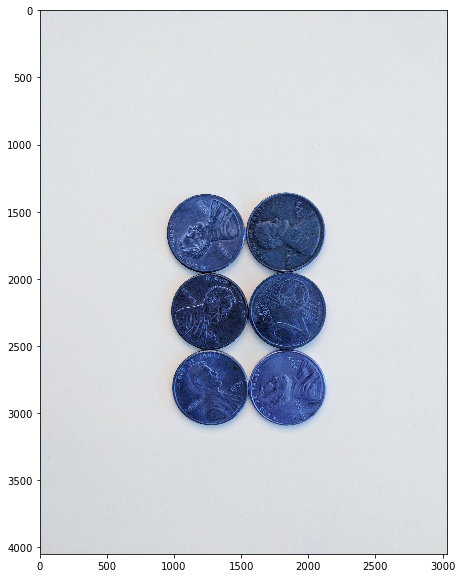

In [62]:
sep_coins = cv2.imread('../DATA/pennies.jpg')
display(sep_coins)

We now need to segment this image into 7 segments: 6 pennies and background.

**Segmentation without watershed:**

Steps:
* Median Blur
* Convert to grayscale
* Binary Threshold
* Find contours

In [63]:
sep_blur = cv2.medianBlur(sep_coins, ksize=25)
#We are taking a large kernel size because of the size of the image

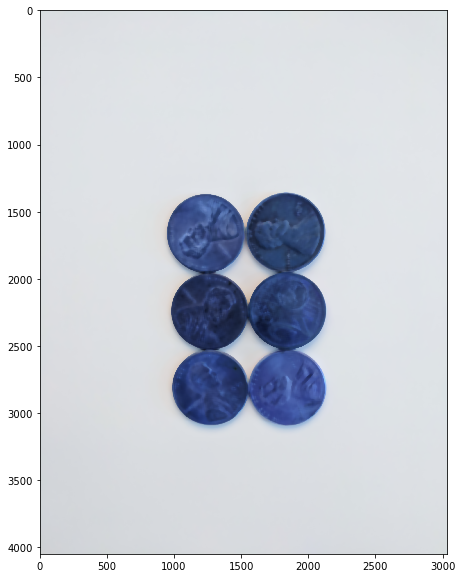

In [64]:
display(sep_blur)

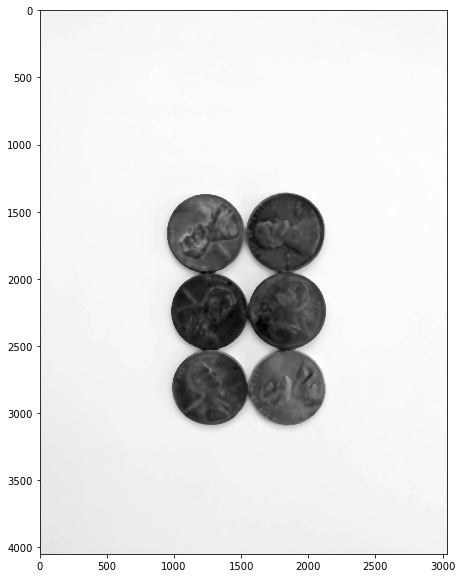

In [65]:
gray_sep_coins = cv2.cvtColor(sep_blur,cv2.COLOR_BGR2GRAY)
display(gray_sep_coins)

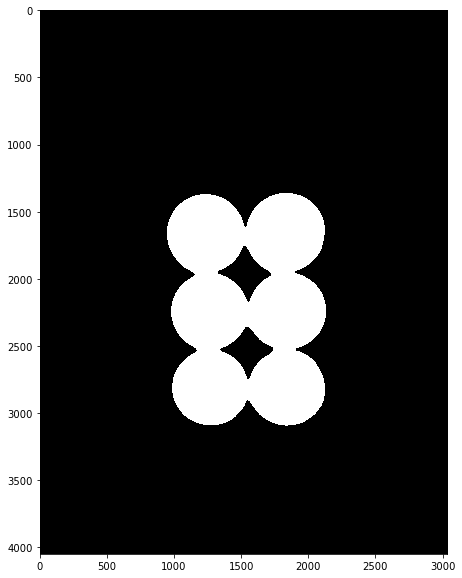

In [66]:
ret, sep_thresh = cv2.threshold(gray_sep_coins, 160, 255, cv2.THRESH_BINARY_INV)
display(sep_thresh)

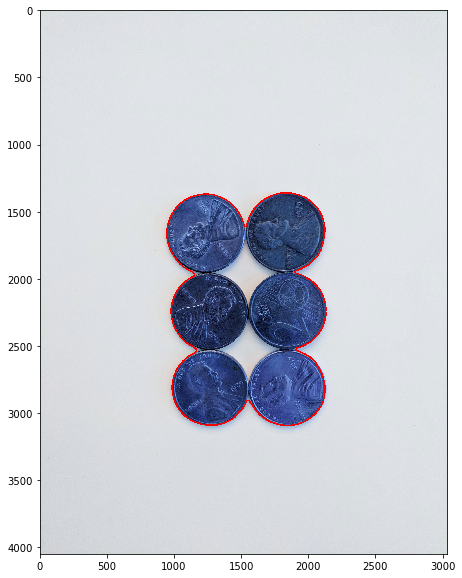

In [67]:
image, contours, hierarchy = cv2.findContours(sep_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):

    if hierarchy[0][i][3] == -1:

        cv2.drawContours(sep_coins, contours, i, (255,0,0),10)

display(sep_coins)

Using the methods we already know, we could only separate these coins as one big contour. But we want to separate each coin. So we will now use watershed algorithm to do so.

### **Segmenting images using watershed algorithm:**

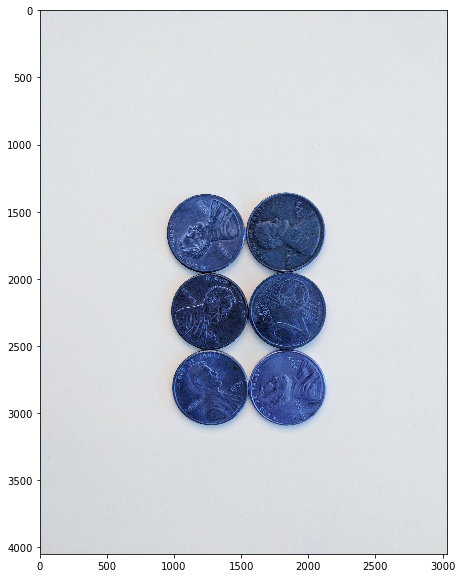

In [68]:
img = cv2.imread('../DATA/pennies.jpg')
display(img)

In [69]:
img=cv2.medianBlur(img,35)

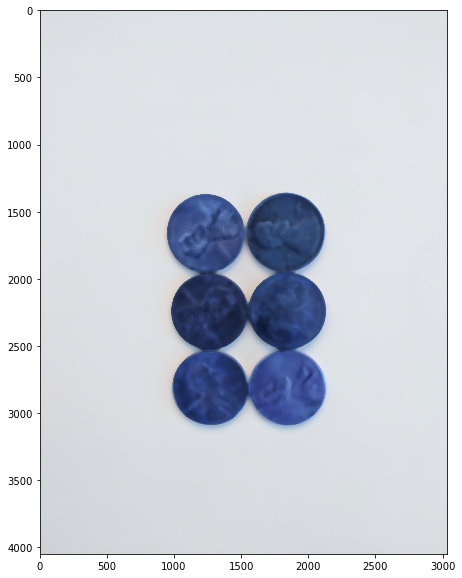

In [70]:
display(img)

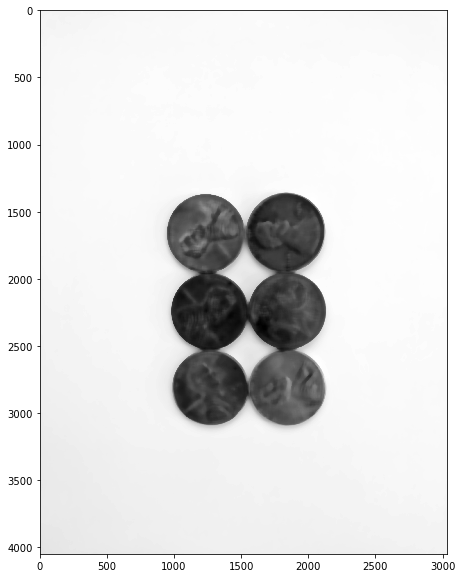

In [71]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
display(gray)

In [72]:
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

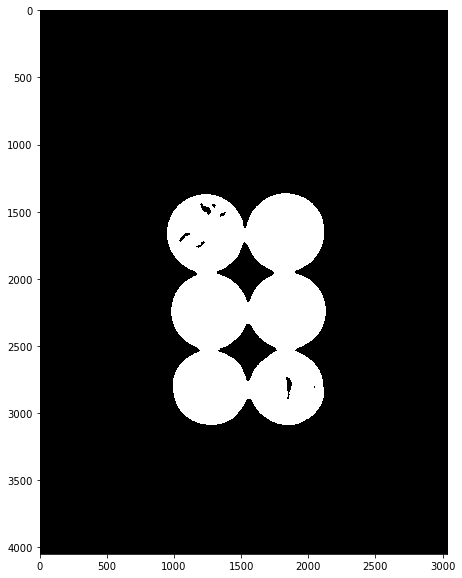

In [73]:
display(thresh)

We can see some noise right now, what we want is distince perfect circles.

In [74]:
#Applying Otsu's Method for thresholding (works very well for watershed algorithm):
new_ret, new_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

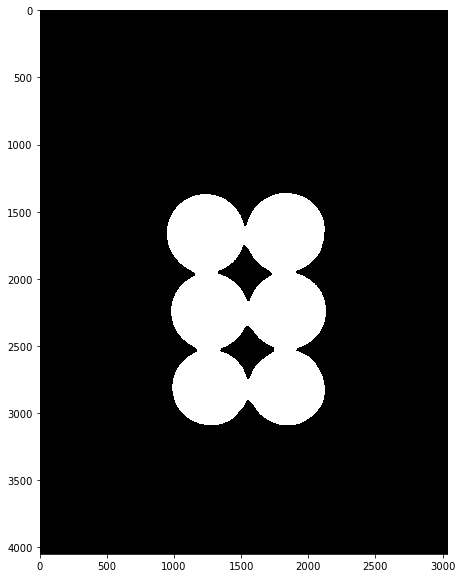

In [75]:
display(new_thresh)

In [76]:
#Though noise removal isn't required here, we'll apply it nonetheless because it is common practice
kernel = np.ones((3,3),np.uint8)
kernel

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

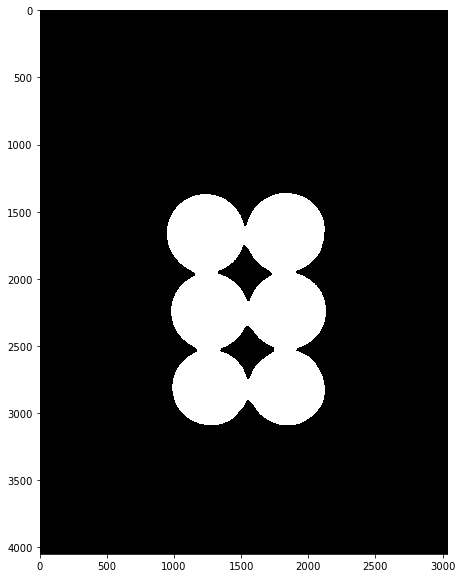

In [77]:
opening = cv2.morphologyEx(new_thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
display(opening)

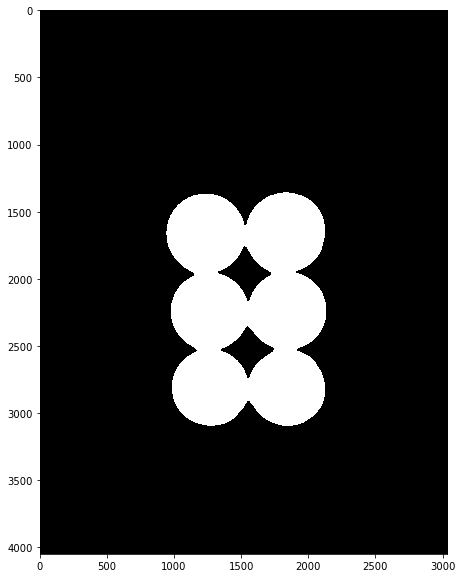

In [78]:
sure_bg = cv2.dilate(opening, kernel, iterations=3)
display(sure_bg)

The problem of no separation between coins still remains. We can apply erosion but it will shrink the outer boundary overall. 
We need to use something called *seeds* to separate these 6 coins.

Watershed segmentation is a region-based technique that utilizes image morphology. It requires selection of at least one marker (“seed” point) interior to each object of the image, including the background as a separate object. The markers are chosen by an operator or are provided by an automatic procedure that takes into account the application-specific knowledge of the objects. Once the objects are marked, they can be grown using a morphological watershed transformation.

To understand the watershed, one can think of an image as a surface where the bright pixels represent mountaintops and the dark pixels valleys. The surface is punctured in some of the valleys, and then slowly submerged into a water bath. The water will pour in each puncture and start to fill the valleys. However, the water from different punctures is not allowed to mix, and therefore the dams need to be built at the points of first contact. These dams are the boundaries of the water basins, and also the boundaries of image objects.

* We need to set seeds, that we're sure are in the foreground.
* We want one seed for centres of each circle
* To do this, we can use "Distance Transform."

The distance transform is an operator normally only applied to binary images. The result of the transform is a graylevel image that looks similar to the input image, except that the graylevel intensities of points inside foreground regions are changed to show the distance to the closest boundary from each point. 

One way to think about the distance transform is to first imagine that foreground regions in the input binary image are made of some uniform slow burning inflammable material. Then consider simultaneously starting a fire at all points on the boundary of a foreground region and letting the fire burn its way into the interior. If we then label each point in the interior with the amount of time that the fire took to first reach that point, then we have effectively computed the distance transform of that region. Matrix below shows a distance transform for a simple rectangular shape. 

$$\begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 1 & 1 & 1 & 1 & 1 & 0 \\ 0 & 1 & 1 & 1 & 1 & 1 & 1 & 0 \\ 0 & 1 & 1 & 1 & 1 & 1 & 1 & 0 \\ 0 & 1 & 1 & 1 & 1 & 1 & 1 & 0 \\ 0 & 1 & 1 & 1 & 1 & 1 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}$$

After Distance Transform:

$$\begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 1 & 1 & 1 & 1 & 1 & 0 \\ 0 & 1 & 2 & 2 & 2 & 2 & 1 & 0 \\  0 & 1 & 2 & 3 & 3 & 2 & 1 & 0 \\ 0 & 1 & 2 & 2 & 2 & 2 & 1 & 0 \\ 0 & 1 & 1 & 1 & 1 & 1 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}$$

0 --> represents background <br>
as distance is increased, you get to foreground, and pixels keep getting brighter.

We can apply distance transform to our threshold right now. <br>
After applying, we can expect the centres of each segment to be bright and then slowly fade away to a dark gray as you go towards the centre. <br>
Then we can rethreshold again to get 6 points.

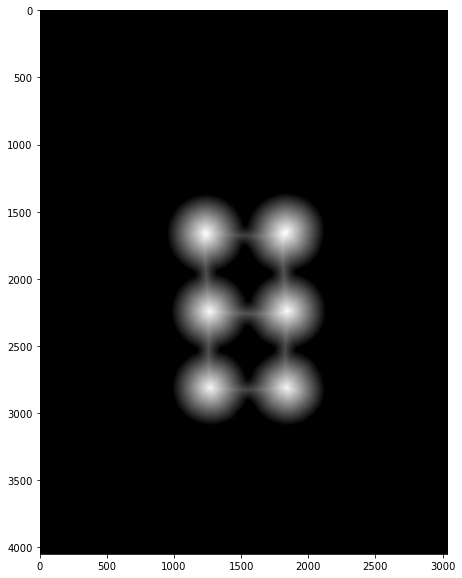

In [79]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5) #DIST_L2 is a method of distancetransform and 5 is a default value for masksize parameter
display(dist_transform)

We need to apply thresholding again to obtain centre points. And then we will give those points to watershed algorithm to form 6 segments.

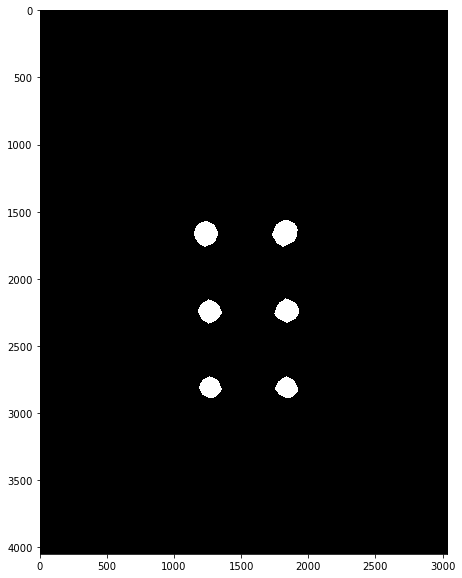

In [80]:
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
#sure_fg --> sure foreground
display(sure_fg)

These 6 points are definitely in the foreground

Now that there is sure bg and sure fg, there is this in between section. Anything in between the bg and fg is the unknown region.

That's what we need watershed algorithm to figure out.

In [81]:
sure_fg = np.uint8(sure_fg)

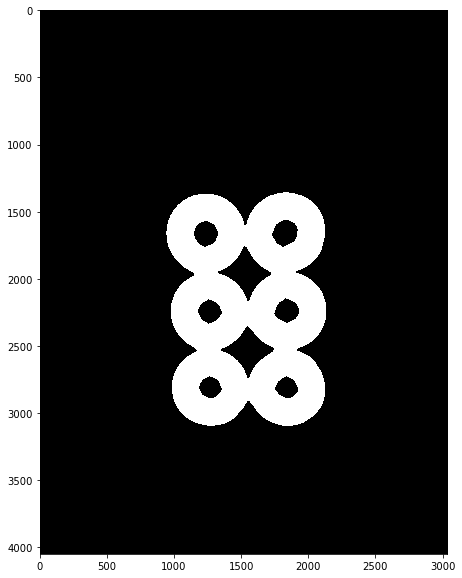

In [82]:
unknown_region = cv2.subtract(sure_bg, sure_fg)
display(unknown_region)

This region doesn't belong to background or foreground. We need to create label markers for watershed algorithm implementation.

In [83]:
ret, markers = cv2.connectedComponents(sure_fg)
markers

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [84]:
markers = markers + 1
#we're doing this because now we'll label the unknown region as 0s

In [85]:
markers

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

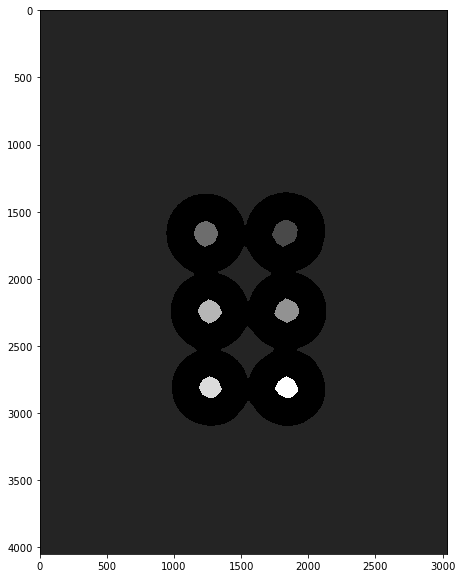

In [87]:
markers[unknown_region==255]=0
display(markers)
#The black region is unknown

In [88]:
#Applying watershed algorithm:
markers = cv2.watershed(img, markers)

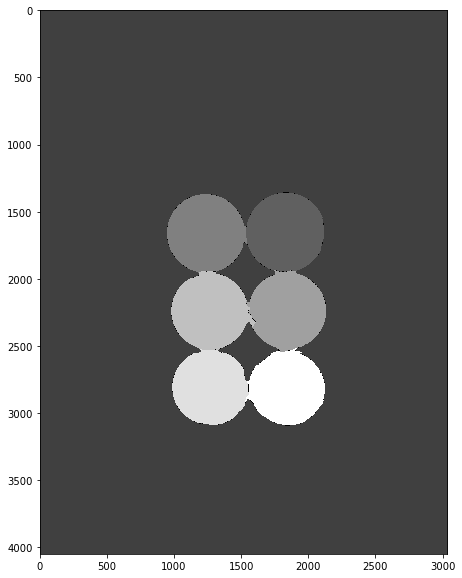

In [89]:
display(markers)

Each circle has a different shade

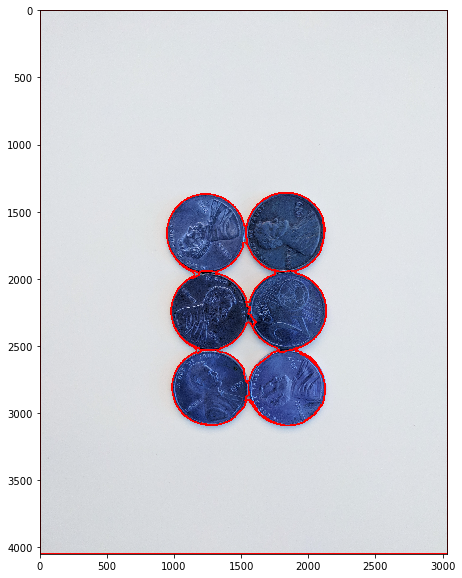

In [90]:
image, contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):

    if hierarchy[0][i][3] == -1:

        cv2.drawContours(sep_coins, contours, i, (255,0,0),10)

display(sep_coins)